In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
img = plt.imread("lenna.png") * 255

In [3]:
gray = img.mean(axis=-1)

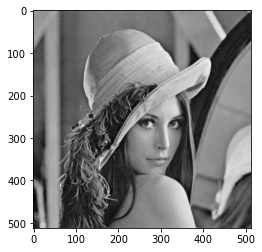

In [4]:
plt.figure()
plt.imshow(gray, cmap = "gray")
plt.show()

In [5]:
high,wide = gray.shape[:2]

step1 高斯滤波

In [6]:
sigma = 0.5 # 方差

In [7]:
dim = int(np.around(sigma * 6) + 1)

In [8]:
if dim % 2 == 0:
    dim += 1

In [9]:
# 高斯分布函数中的参数
n1 = 1 / (2 * np.pi * sigma ** 2) 
n2 = -1 / (2 * sigma ** 2)

In [10]:
# 生成对称区间
temp = [i - dim//2 for i in range(dim)]

In [11]:
temp

[-2, -1, 0, 1, 2]

In [12]:
# 高斯滤波器模板
Gaussian_filter = np.zeros((dim, dim))

In [13]:
# 生成高斯滤波器
for x in range(dim):
    for y in range(dim):
        Gaussian_filter[x, y] = n1 * np.exp(n2 * (temp[x] ** 2 + temp[y] ** 2))
Gaussian_filter = Gaussian_filter / Gaussian_filter.sum()

In [14]:
# 滤波前对图像补零
tmp = dim // 2
img_pad = np.pad(gray, ((tmp, tmp), (tmp, tmp)), "constant")

In [15]:
# 滤波后模板
img_filtered = np.zeros((wide, high))

In [16]:
# 开始滤波
for x in range(high):
    for y in range(wide):
        img_filtered[x, y] = np.sum(img_pad[x: x+dim, y: y+dim] * Gaussian_filter)

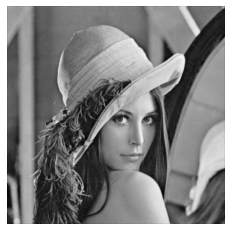

In [17]:
plt.figure()
plt.imshow(img_filtered, cmap="gray")
plt.axis("off")
plt.show()

setp 2 sobel算子求梯度

In [18]:
# sobel 算子
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [19]:
img_grad_x = np.zeros((wide, high))
img_grad_y = np.zeros((wide, high))
img_grad = np.zeros((wide, high))

In [20]:
# 对目标图像补零
img_pad = np.pad(img_filtered, ((1,1),(1,1)), "constant")

In [21]:
for x in range(high):
    for y in range(wide):
        img_grad_x[x, y] = np.sum(img_pad[x: x + 3, y: y + 3] * sobel_kernel_x)
        img_grad_y[x, y] = np.sum(img_pad[x: x + 3, y: y + 3] * sobel_kernel_y)
        img_grad[x, y] = np.sqrt(img_grad_x[x, y] ** 2 + img_grad_y[x, y] ** 2)

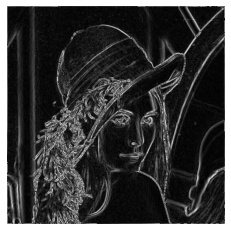

In [22]:
plt.figure()
plt.imshow(img_grad.astype(np.uint8), cmap="gray")
plt.axis("off")
plt.show()

In [23]:
# 像素点梯度斜率
img_grad_x[img_grad_x == 0] = 0.00000001
angle_tan = img_grad_y / img_grad_x

step 3 非极大值抑制

In [24]:
img_restrain = np.zeros((wide, high))

# 线性插值判断是否抑制
for x in range(1, high-1):
    for y in range(1, wide-1):
        a = img_grad[x-1:x+2, y-1:y+2]
        flag = True
        if angle_tan[x, y] <= -1:
            num_1 = (a[0, 1] - a[0, 0]) / angle_tan[x, y] + a[0, 1]
            num_2 = (a[2, 1] - a[2, 2]) / angle_tan[x, y] + a[2, 1]
            if not(img_grad[x, y] > num_1 and img_grad[x, y] > num_2):
                flag = False
        elif angle_tan[x, y] >=1:
            num_1 = (a[0, 2] - a[0, 1]) / angle_tan[x, y] + a[0, 1]
            num_2 = (a[2, 0] - a[2, 1]) / angle_tan[x, y] + a[2, 1]
            if not(img_grad[x, y] > num_1 and img_grad[x, y] > num_2):
                flag = False
        elif angle_tan[x, y] > 0:
            num_1 = (a[0, 2] - a[1, 2]) * angle_tan[x, y] + a[1, 2]
            num_2 = (a[2, 0] - a[1, 0]) * angle_tan[x, y] + a[1, 0]
            if not(img_grad[x, y] > num_1 and img_grad[x, y] > num_2):
                flag = False
        elif angle_tan[x, y] < 0:
            num_1 = (a[1, 2] - a[2, 2]) * angle_tan[x, y] + a[1, 2]
            num_2 = (a[1, 0] - a[0, 0]) * angle_tan[x, y] + a[1, 0]
            if not(img_grad[x, y] > num_1 and img_grad[x, y] > num_2):
                flag = False

        if flag:
            img_restrain[x, y] = img_grad[x, y]

step3 双阈值检测

In [25]:
#  设置阈值
low_boundary = img_grad.mean() * 0.5
high_boundary = low_boundary * 3

In [26]:
stack = []

In [27]:
for x in range(1, high-1):
    for y in range(1, wide-1):
        if img_restrain[x, y] > high_boundary:
            img_restrain[x, y] = 255
            stack.append([x, y])
        elif img_restrain[x, y] < low_boundary:
            img_restrain[x, y] = 0

In [28]:
while not len(stack)==0:
    temp_1, temp_2 = stack.pop()
    a = img_restrain[temp_1-1:temp_1+2, temp_2-1:temp_2+2]
    if a[0, 0] > low_boundary and a[0, 0] < high_boundary:
        img_restrain[temp_1-1, temp_2-1] = 255
        stack.append([temp_1-1, temp_2-1])
    if a[0, 1] > low_boundary and a[0, 1] < high_boundary:
        img_restrain[temp_1-1, temp_2] = 255
        stack.append([temp_1-1, temp_2])
    if a[0, 2] > low_boundary and a[0, 2] < high_boundary:
        img_restrain[temp_1-1, temp_2+1] = 255
        stack.append([temp_1 -1 , temp_2 + 1])
    if a[1, 0] > low_boundary and a[1, 0] < high_boundary:
        img_restrain[temp_1, temp_2 - 1] = 255
        stack.append([temp_1, temp_2 - 1])
    if a[1, 2] > low_boundary and a[1, 2] < high_boundary:
        img_restrain[temp_1 , temp_2+1] = 255
        stack.append([temp_1, temp_2 + 1])
    if a[2, 0] > low_boundary and a[2, 0] < high_boundary:
        img_restrain[temp_1 + 1, temp_2 - 1] = 255
        stack.append([temp_1 + 1, temp_2 - 1])
    if a[2, 1] > low_boundary and a[2, 1] < high_boundary:
        img_restrain[temp_1 + 1, temp_2] = 255
        stack.append([temp_1+1, temp_2])
    if a[2, 2] > low_boundary and a[2, 2] < high_boundary:
        img_restrain[temp_1 + 1, temp_2 + 2]
        stack.append([temp_1 + 1, temp_2 + 1])

In [29]:
for x in range(high):
    for y in range(wide):
        if img_restrain[x, y] != 0 and img_restrain[x, y] != 255:
            img_restrain[x, y] = 0

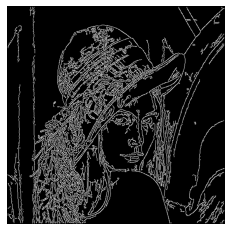

In [32]:
plt.figure()
plt.imshow(img_restrain.astype(np.uint8), cmap="gray")
plt.axis("off")
plt.show()

In [33]:
cv2.imshow("edge", img_restrain)
cv2.waitKey(0)

-1